In [2]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import plot, show
%matplotlib inline

In [ ]:
col = ["day","mean"]
mp = pd.DataFrame(columns = col)
checkerDuplicates = set()

for year in range(1995, 2019):
    print(year)
    if year <= 2015:
        t = pd.read_excel('datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(year)+'.xlsx')
    else:
        t = pd.read_excel('datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(year)+'.xls')
    if year == 2011:
        tmpi = 0
    for i, row in t.iterrows():
        tmpl = []
        if year == 2011:
            if tmpi < 2:
                continue
            else: 
               tmpl = [row[0], np.mean(row[1:-2]), row[-2]]
            tmpi += 1
        else:
            if (i < 2):
                continue
            if year in [1995,1996,1997,1998,1999,2001,2002,2003,2004,2006,2007,2008,2009,]:
                tmpl = [row[0], np.max(np.mean(row[1:]))]
            elif year in [2000,2005,2010,2015,2016,2017,2018]: 
                tmpl = [row[0], np.mean(row[1:-1])]
            else:
                tmpl = [row[0], np.mean(row[1:-2])]
        if tmpl[0] is np.nan:
            continue
        if not isinstance(tmpl[0], str):
            tmpl[0] = "{:%Y-%m-%d}".format(tmpl[0])
            
        if not tmpl[0] in checkerDuplicates:
            mp.loc[len(mp), :] = tmpl
            checkerDuplicates.add(tmpl[0])


1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006


In [3]:
mp.head()
mp.to_csv('allYearPrices.csv')


In [8]:
mp.head()

,day,mean
0,1995-07-20,1.40943
1,1995-07-21,4.92433
2,1995-07-22,1.2695
3,1995-07-23,0.953083
4,1995-07-24,4.30592


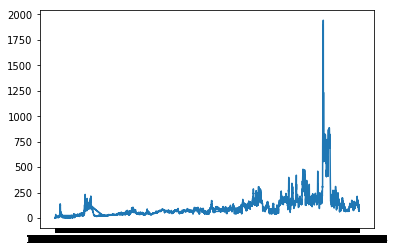

In [12]:
plot(mp['day'].tolist(), mp['mean'].tolist())
show()